## **Europa's Magnetosphere Modeling using Physics-Informed Neural Networks**

### Astronomical Introduction

#### Europa: A Moon of Jupiter

Europa is one of the four Galilean moons of Jupiter, discovered by Galileo Galilei in 1610. As the smallest of the four, with a diameter of approximately 3,122 km (about 90% the size of Earth's Moon), Europa holds extraordinary scientific interest for several reasons:

- **Icy Surface**: Europa is covered with a smooth, icy crust exhibiting a complex pattern of cracks and ridges, indicating ongoing geological activity
- **Subsurface Ocean**: Beneath the ice shell lies a vast subsurface ocean of liquid water, estimated to contain more water than all of Earth's oceans combined
- **Potential Habitability**: The combination of liquid water, energy from tidal heating, and chemical interactions between the water and rock make Europa one of the most promising locations in our solar system to search for extraterrestrial life

#### Jupiter's Powerful Magnetic Field

Jupiter possesses one of the strongest magnetic fields in the solar system, approximately 20,000 times more powerful than Earth's magnetic field at its equator. Key characteristics include:

- **Vast Magnetosphere**: Jupiter's magnetosphere extends millions of kilometers into space, creating a region where charged particles are trapped and accelerated
- **Influence on Moons**: The magnetic field significantly influences the environment of Jupiter's moons, including Europa
- **Plasma Interactions**: The interaction between Jupiter's magnetosphere and Europa's ionosphere creates complex plasma phenomena that affect the magnetic field structure around the moon

#### Galileo Mission: Mapping Europa's Magnetosphere

The Galileo spacecraft, which orbited Jupiter from 1995 to 2003, conducted multiple close flybys of Europa. These flybys provided direct measurements of the magnetic field in Europa's vicinity, yielding invaluable data about:

- **Local Magnetic Field Structure**: Direct measurements of magnetic field components near Europa's surface
- **Induction Signatures**: Evidence of Europa's subsurface ocean through electromagnetic induction effects
- **Multiple Orbital Passes**: Different flybys (orbits 4, 11, and 14 are analyzed here) captured the magnetic field from various trajectories and distances

The Galileo data remains the most comprehensive dataset of Europa's local magnetic environment and is crucial for understanding the moon's magnetospheric interactions.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

# Load and preprocess data
df1 = pd.read_csv("data/ORB04_EUR_EPHIO.csv")
df1 = df1.dropna()
X1 = df1[['SPACECRAFT EVENT TIME','BX','BY','BZ','B-FIELD MAGNITUDE','X','Y','Z']].values

df2 = pd.read_csv("data/ORB04_EUR_ESPRH.csv")
df2 = df2.dropna()
X2 = df2[['SPACECRAFT EVENT TIME','BR','BTHETA','BPHI','B-FIELD MAGNITUDE','RANGE','LATITUDE','LONGITUDE']].values

X = X2.copy()
X = X[:,(1, 2, 3, 5, 6, 7)]

X3 = np.concatenate((X1, X), axis=1)

X = X3
x = np.linspace(0, 8775, 8775)

### Initial Data Visualization

The plots below show the temporal evolution of the magnetic field measurements during the Galileo spacecraft's flyby of Europa. Each subplot reveals different aspects of the data:

- **Cartesian Components**: BX, BY, BZ measured in Jupiter-centered coordinates
- **Spherical Components**: BR (radial), BTHETA (polar), BPHI (azimuthal) measured in Europa-centric coordinates  
- **Magnitude**: The overall strength of the magnetic field
- **Spacecraft Position**: The trajectory of the Galileo spacecraft in both coordinate systems

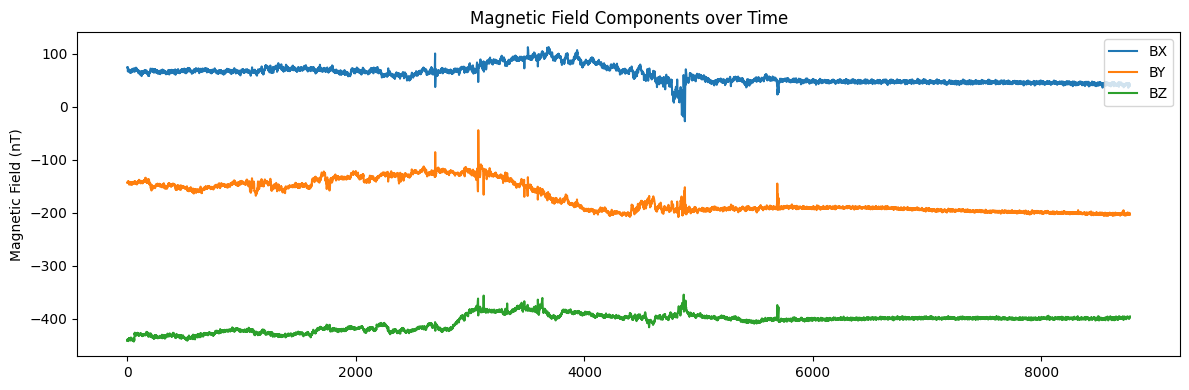

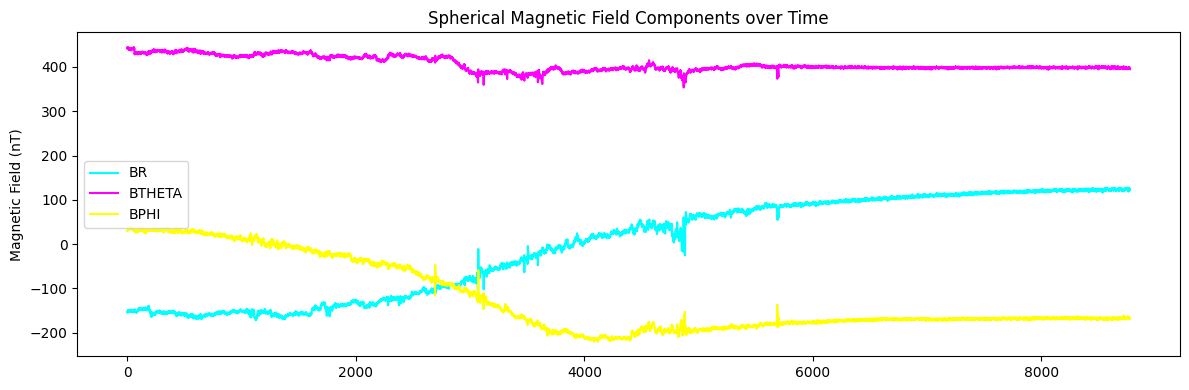

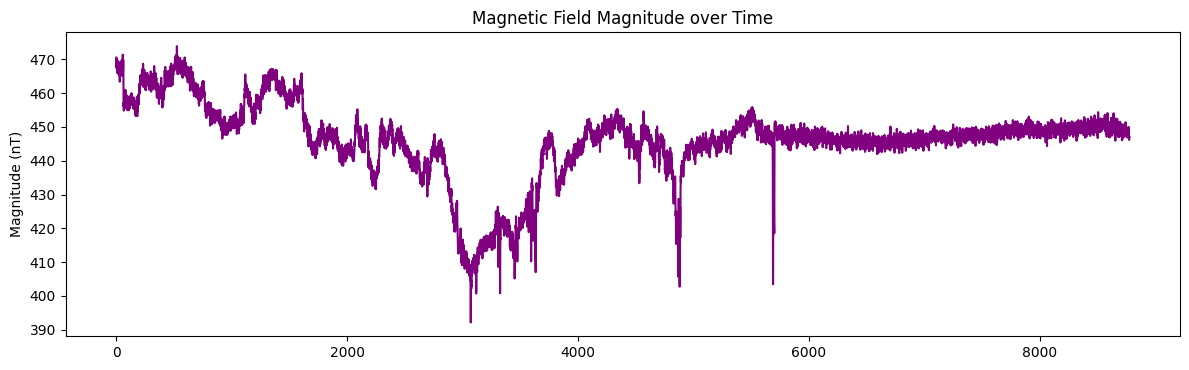

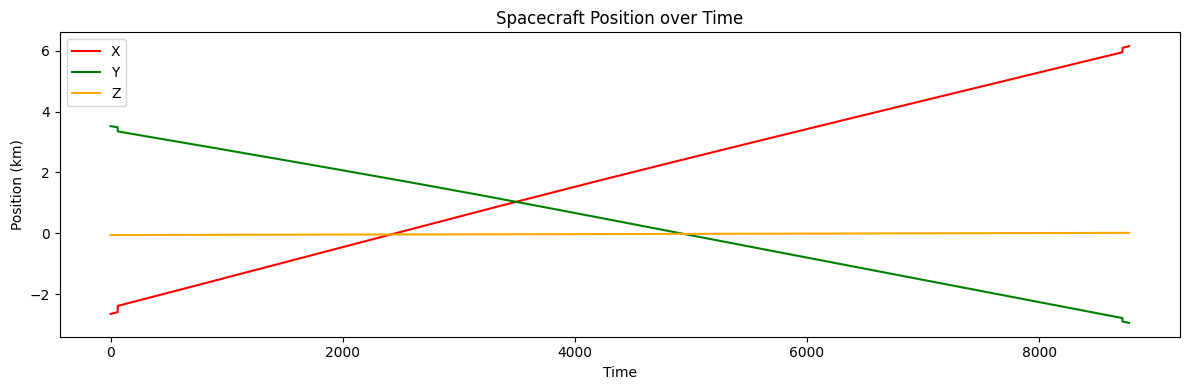

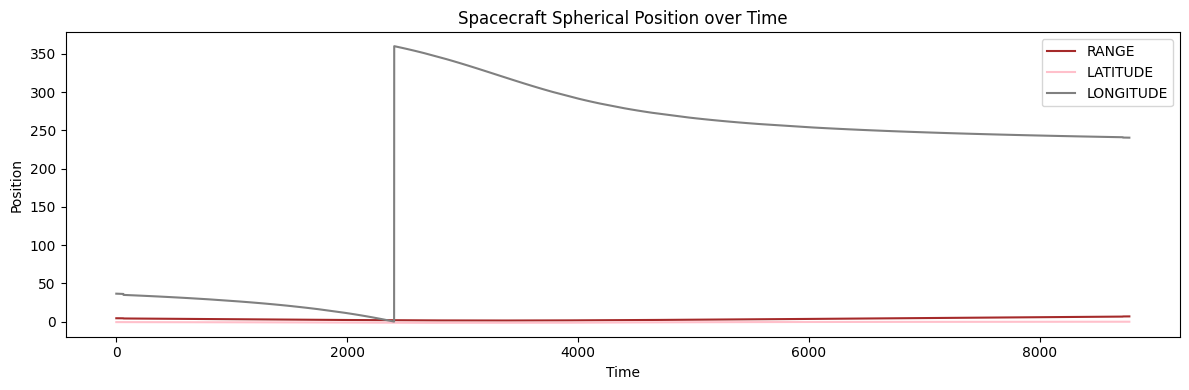

In [2]:
# Separate figures for each plot to avoid squeezing
plt.figure(figsize=(12, 4))
plt.plot(x, X[:,1], label='BX')
plt.plot(x, X[:,2], label='BY')
plt.plot(x, X[:,3], label='BZ')
plt.title('Magnetic Field Components over Time')
plt.ylabel('Magnetic Field (nT)')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(x, X[:,8], label='BR', color='cyan')
plt.plot(x, X[:,9], label='BTHETA', color='magenta')
plt.plot(x, X[:,10], label='BPHI', color='yellow')
plt.title('Spherical Magnetic Field Components over Time')
plt.ylabel('Magnetic Field (nT)')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 3.8))
plt.plot(x, X[:,4], color='purple')
plt.title('Magnetic Field Magnitude over Time')
plt.ylabel('Magnitude (nT)')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(x, X[:,5], label='X', color='red')
plt.plot(x, X[:,6], label='Y', color='green')
plt.plot(x, X[:,7], label='Z', color='orange')
plt.title('Spacecraft Position over Time')
plt.xlabel('Time')
plt.ylabel('Position (km)')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(x, X[:,11], label='RANGE', color='brown')
plt.plot(x, X[:,12], label='LATITUDE', color='pink')
plt.plot(x, X[:,13], label='LONGITUDE', color='gray')
plt.title('Spacecraft Spherical Position over Time')
plt.xlabel('Time')
plt.ylabel('Position')
plt.legend()
plt.tight_layout()
plt.show()

### Coordinate System Transformation

The raw Galileo data comes in multiple coordinate systems. Understanding these is crucial for correct interpretation:

- **EPHIO (Jupiter-Centered Coordinates)**: Measures positions and magnetic field relative to Jupiter's center. Useful for understanding the global context but less useful for analyzing local phenomena at Europa
- **ESPRH (Europa-Centric Spherical Coordinates)**: Measures positions relative to Europa's center using spherical coordinates (Range, Latitude, Longitude) and magnetic field components in the spherical basis (Radial, Poloidal, Toroidal)

In the analysis below, we focus on ESPRH coordinates, which provide a natural reference frame for studying Europa's local magnetosphere. The transformation from spherical to Cartesian coordinates allows us to visualize the data in 3D space and to perform the neural network analysis.

### Multi-Flyby Trajectory Analysis

Galileo conducted multiple close flybys of Europa at different distances and orientations. Here we analyze three significant flybys:

- **Orbit 04 (Blue)**
- **Orbit 11 (Red)**
- **Orbit 14 (Green)**

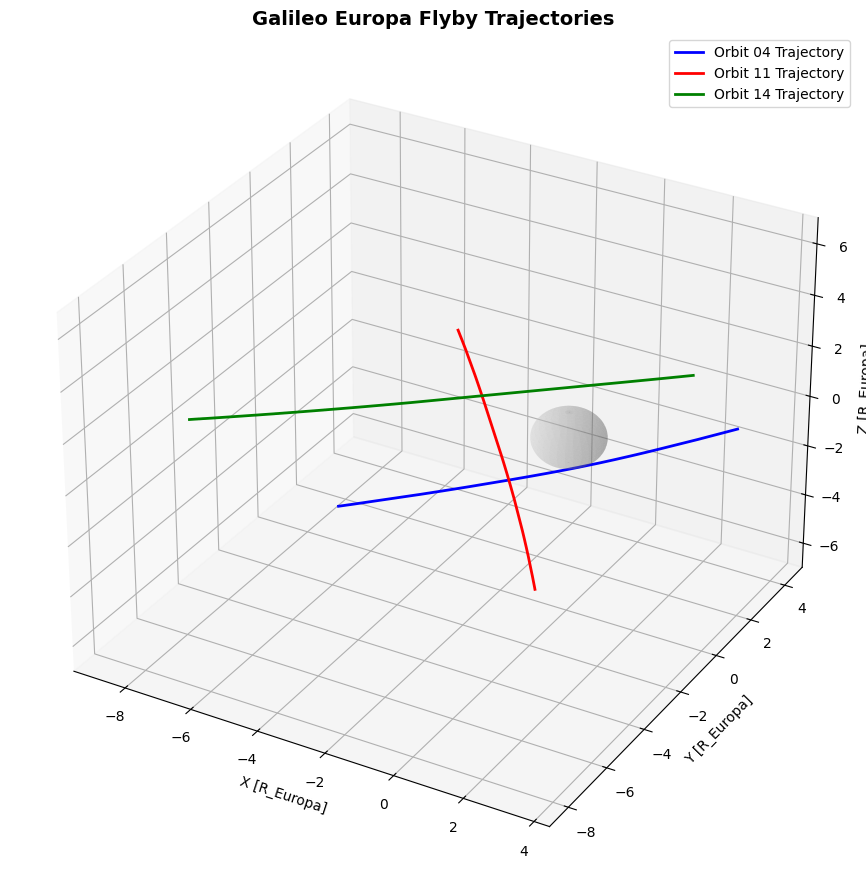

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load ESPRH spherical data for all 3 flybys
df1 = pd.read_csv("data/ORB04_EUR_ESPRH.csv", parse_dates=["SPACECRAFT EVENT TIME"])
df2 = pd.read_csv("data/ORB11_EUR_ESPRH.csv", parse_dates=["SPACECRAFT EVENT TIME"])
df3 = pd.read_csv("data/ORB14_EUR_ESPRH.csv", parse_dates=["SPACECRAFT EVENT TIME"])

# Down-sample for legibility
stride = max(len(df1) // 2000, 1)
d1 = df1.iloc[::stride].copy()
stride2 = max(len(df2) // 2000, 1)
d2 = df2.iloc[::stride2].copy()
stride3 = max(len(df3) // 2000, 1)
d3 = df3.iloc[::stride3].copy()

# Spherical -> Cartesian positions for flyby 1
theta = np.deg2rad(90.0 - d1["LATITUDE"].to_numpy())
phi = np.deg2rad(d1["LONGITUDE"].to_numpy())
r = d1["RANGE"].to_numpy()
x1 = r * np.sin(theta) * np.cos(phi)
y1 = r * np.sin(theta) * np.sin(phi)
z1 = r * np.cos(theta)

# Spherical -> Cartesian positions for flyby 2
theta2 = np.deg2rad(90.0 - d2["LATITUDE"].to_numpy())
phi2 = np.deg2rad(d2["LONGITUDE"].to_numpy())
r2 = d2["RANGE"].to_numpy()
x2 = r2 * np.sin(theta2) * np.cos(phi2)
y2 = r2 * np.sin(theta2) * np.sin(phi2)
z2 = r2 * np.cos(theta2)

# Spherical -> Cartesian positions for flyby 3
theta3 = np.deg2rad(90.0 - d3["LATITUDE"].to_numpy())
phi3 = np.deg2rad(d3["LONGITUDE"].to_numpy())
r3 = d3["RANGE"].to_numpy()
x3 = r3 * np.sin(theta3) * np.cos(phi3)
y3 = r3 * np.sin(theta3) * np.sin(phi3)
z3 = r3 * np.cos(theta3)

fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(projection="3d")

# Europa sphere (radius = 1 R_Europa)
u = np.linspace(0, 2*np.pi, 60)
v = np.linspace(0, np.pi, 30)
xs = np.outer(np.cos(u), np.sin(v))
ys = np.outer(np.sin(u), np.sin(v))
zs = np.outer(np.ones_like(u), np.cos(v))
ax.plot_surface(xs, ys, zs, color="lightgray", alpha=0.25, linewidth=0, zorder=0)

ax.plot3D(x1, y1, z1, color='blue', label='Orbit 04 Trajectory', linewidth=2)
ax.plot3D(x2, y2, z2, color='red', label='Orbit 11 Trajectory', linewidth=2)
ax.plot3D(x3, y3, z3, color='green', label='Orbit 14 Trajectory', linewidth=2)
ax.set_xlabel("X [R_Europa]")
ax.set_ylabel("Y [R_Europa]")
ax.set_zlabel("Z [R_Europa]")
ax.set_title("Galileo Europa Flyby Trajectories", fontsize=14, fontweight='bold')
ax.legend()

# Equal-ish aspect
lims = np.array([ax.get_xlim3d(), ax.get_ylim3d(), ax.get_zlim3d()])
center = lims.mean(axis=1)
radius = (lims[:,1] - lims[:,0]).max() / 2
ax.set_xlim3d([center[0]-radius, center[0]+radius])
ax.set_ylim3d([center[1]-radius, center[1]+radius])
ax.set_zlim3d([center[2]-radius, center[2]+radius])
plt.tight_layout()
plt.show()

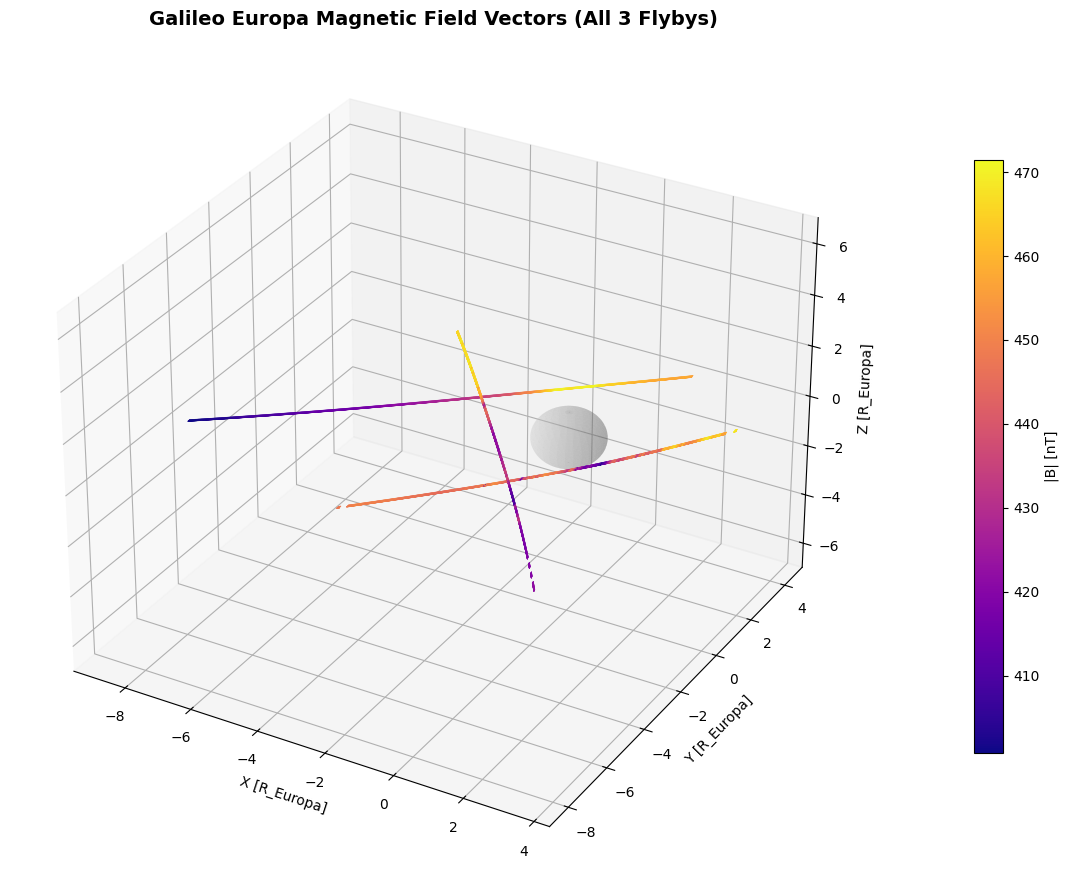

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import plasma

# Load ESPRH spherical data for all 3 flybys
df1 = pd.read_csv("data/ORB04_EUR_ESPRH.csv", parse_dates=["SPACECRAFT EVENT TIME"])
df2 = pd.read_csv("data/ORB11_EUR_ESPRH.csv", parse_dates=["SPACECRAFT EVENT TIME"])
df3 = pd.read_csv("data/ORB14_EUR_ESPRH.csv", parse_dates=["SPACECRAFT EVENT TIME"])

# Down-sample for legibility
stride1 = max(len(df1) // 2000, 1)
d1 = df1.iloc[::stride1].copy()
stride2 = max(len(df2) // 2000, 1)
d2 = df2.iloc[::stride2].copy()
stride3 = max(len(df3) // 2000, 1)
d3 = df3.iloc[::stride3].copy()

# Spherical -> Cartesian positions for flyby 1
theta = np.deg2rad(90.0 - d1["LATITUDE"].to_numpy())
phi = np.deg2rad(d1["LONGITUDE"].to_numpy())
r = d1["RANGE"].to_numpy()
x1 = r * np.sin(theta) * np.cos(phi)
y1 = r * np.sin(theta) * np.sin(phi)
z1 = r * np.cos(theta)

# Spherical -> Cartesian positions for flyby 2
theta2 = np.deg2rad(90.0 - d2["LATITUDE"].to_numpy())
phi2 = np.deg2rad(d2["LONGITUDE"].to_numpy())
r2 = d2["RANGE"].to_numpy()
x2 = r2 * np.sin(theta2) * np.cos(phi2)
y2 = r2 * np.sin(theta2) * np.sin(phi2)
z2 = r2 * np.cos(theta2)

# Spherical -> Cartesian positions for flyby 3
theta3 = np.deg2rad(90.0 - d3["LATITUDE"].to_numpy())
phi3 = np.deg2rad(d3["LONGITUDE"].to_numpy())
r3 = d3["RANGE"].to_numpy()
x3 = r3 * np.sin(theta3) * np.cos(phi3)
y3 = r3 * np.sin(theta3) * np.sin(phi3)
z3 = r3 * np.cos(theta3)

# Spherical components -> Cartesian vectors for flyby 1
Br1 = d1["BR"].to_numpy()
Btheta1 = d1["BTHETA"].to_numpy()
Bphi1 = d1["BPHI"].to_numpy()
Bx1 = Br1 * np.sin(theta) * np.cos(phi) + Btheta1 * np.cos(theta) * np.cos(phi) - Bphi1 * np.sin(phi)
By1 = Br1 * np.sin(theta) * np.sin(phi) + Btheta1 * np.cos(theta) * np.sin(phi) + Bphi1 * np.cos(phi)
Bz1 = Br1 * np.cos(theta) - Btheta1 * np.sin(theta)
Bmag1 = np.sqrt(Bx1**2 + By1**2 + Bz1**2)
Bx1_u = Bx1 / Bmag1
By1_u = By1 / Bmag1
Bz1_u = Bz1 / Bmag1

# Spherical components -> Cartesian vectors for flyby 2
Br2 = d2["BR"].to_numpy()
Btheta2 = d2["BTHETA"].to_numpy()
Bphi2 = d2["BPHI"].to_numpy()
Bx2 = Br2 * np.sin(theta2) * np.cos(phi2) + Btheta2 * np.cos(theta2) * np.cos(phi2) - Bphi2 * np.sin(phi2)
By2 = Br2 * np.sin(theta2) * np.sin(phi2) + Btheta2 * np.cos(theta2) * np.sin(phi2) + Bphi2 * np.cos(phi2)
Bz2 = Br2 * np.cos(theta2) - Btheta2 * np.sin(theta2)
Bmag2 = np.sqrt(Bx2**2 + By2**2 + Bz2**2)
Bx2_u = Bx2 / Bmag2
By2_u = By2 / Bmag2
Bz2_u = Bz2 / Bmag2

# Spherical components -> Cartesian vectors for flyby 3
Br3 = d3["BR"].to_numpy()
Btheta3 = d3["BTHETA"].to_numpy()
Bphi3 = d3["BPHI"].to_numpy()
Bx3 = Br3 * np.sin(theta3) * np.cos(phi3) + Btheta3 * np.cos(theta3) * np.cos(phi3) - Bphi3 * np.sin(phi3)
By3 = Br3 * np.sin(theta3) * np.sin(phi3) + Btheta3 * np.cos(theta3) * np.sin(phi3) + Bphi3 * np.cos(phi3)
Bz3 = Br3 * np.cos(theta3) - Btheta3 * np.sin(theta3)
Bmag3 = np.sqrt(Bx3**2 + By3**2 + Bz3**2)
Bx3_u = Bx3 / Bmag3
By3_u = By3 / Bmag3
Bz3_u = Bz3 / Bmag3

fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(projection="3d")

# Europa sphere (radius = 1 R_Europa)
u = np.linspace(0, 2*np.pi, 60)
v = np.linspace(0, np.pi, 30)
xs = np.outer(np.cos(u), np.sin(v))
ys = np.outer(np.sin(u), np.sin(v))
zs = np.outer(np.ones_like(u), np.cos(v))
ax.plot_surface(xs, ys, zs, color="lightgray", alpha=0.25, linewidth=0, zorder=0)

norm1 = Normalize(vmin=Bmag1.min(), vmax=Bmag1.max())
colors1 = plasma(norm1(Bmag1))
ax.quiver(
    x1, y1, z1,
    Bx1_u, By1_u, Bz1_u,
    length=0.12, normalize=False, colors=colors1, linewidth=0.4, label='Orbit 04'
)

norm2 = Normalize(vmin=Bmag2.min(), vmax=Bmag2.max())
colors2 = plasma(norm2(Bmag2))
ax.quiver(
    x2, y2, z2,
    Bx2_u, By2_u, Bz2_u,
    length=0.12, normalize=False, colors=colors2, linewidth=0.4, label='Orbit 11'
)

norm3 = Normalize(vmin=Bmag3.min(), vmax=Bmag3.max())
colors3 = plasma(norm3(Bmag3))
ax.quiver(
    x3, y3, z3,
    Bx3_u, By3_u, Bz3_u,
    length=0.12, normalize=False, colors=colors3, linewidth=0.4, label='Orbit 14'
)

mappable = plt.cm.ScalarMappable(norm=norm1, cmap=plasma)
mappable.set_array([])
cbar = fig.colorbar(mappable, ax=ax, pad=0.1, shrink=0.7)
cbar.set_label("|B| [nT]")

ax.set_xlabel("X [R_Europa]")
ax.set_ylabel("Y [R_Europa]")
ax.set_zlabel("Z [R_Europa]")
ax.set_title("Galileo Europa Magnetic Field Vectors (All 3 Flybys)", fontsize=14, fontweight='bold')

# Equal-ish aspect
lims = np.array([ax.get_xlim3d(), ax.get_ylim3d(), ax.get_zlim3d()])
center = lims.mean(axis=1)
radius = (lims[:,1] - lims[:,0]).max() / 2
ax.set_xlim3d([center[0]-radius, center[0]+radius])
ax.set_ylim3d([center[1]-radius, center[1]+radius])
ax.set_zlim3d([center[2]-radius, center[2]+radius])
plt.tight_layout()
plt.show()